# K近邻算法实现红酒聚类

## 实验介绍

K近邻算法（K-Nearest-Neighbor, KNN）是一种用于分类和回归的非参数统计方法，是机器学习最基础的算法之一。KNN是无监督学习算法，无需训练，但是每次预测都需要遍历数据集，效率不高。KNN的三个基本要素：

- K值，一个样本的分类是由K个邻居的“多数表决”确定的。K值越小，容易受噪声影响，反之，会使类别之间的界限变得模糊。
- 距离度量，反映了特征空间中两个样本间的相似度，距离越小，越相似。常用的有Lp距离（p=2时，即为欧式距离）、曼哈顿距离、海明距离等。
- 分类决策规则，通常是多数表决，或者基于距离加权的多数表决（权值与距离成反比）。

本实验主要介绍使用MindSpore在部分wine数据集上进行KNN实验。

## 实验目的

- 了解KNN的基本概念；
- 了解如何使用MindSpore进行KNN实验。

## 预备知识

- 熟练使用Python。
- 具备一定的机器学习理论知识，如KNN、无监督学习、Lp距离等。
- 了解华为云的基本使用方法，包括[OBS（对象存储）](https://www.huaweicloud.com/product/obs.html)、[ModelArts（AI开发平台）](https://www.huaweicloud.com/product/modelarts.html)、[训练作业](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0238.html)等功能。华为云官网：https://www.huaweicloud.com
- 了解并熟悉MindSpore AI计算框架，MindSpore官网：https://www.mindspore.cn/

## 实验环境

- MindSpore 1.3.0（MindSpore版本会定期更新，本指导也会定期刷新，与版本配套）；
- 华为云ModelArts（控制台左上角选择“华北-北京四”）：ModelArts是华为云提供的面向开发者的一站式AI开发平台，集成了昇腾AI处理器资源池，用户可以在该平台下体验MindSpore。

## 实验过程

### 步骤一 数据准备
#### 下载数据

Wine数据集是模式识别最著名的数据集之一，Wine数据集的官网：[Wine Data Set](http://archive.ics.uci.edu/ml/datasets/Wine)。这些数据是对来自意大利同一地区但来自三个不同品种的葡萄酒进行化学分析的结果。数据集分析了三种葡萄酒中每种所含13种成分的量。这些13种属性是

1. Alcohol，酒精
2. Malic acid，苹果酸
3. Ash，灰
4. Alcalinity of ash，灰的碱度
5. Magnesium，镁
6. Total phenols，总酚
7. Flavanoids，类黄酮
8. Nonflavanoid phenols，非黄酮酚
9. Proanthocyanins，原花青素
10. Color intensity，色彩强度
11. Hue，色调
12. OD280/OD315 of diluted wines，稀释酒的OD280/OD315
13. Proline，脯氨酸

- 方式一，从Wine数据集官网下载[wine.data文件](http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data)。
- 方式二，从华为云OBS中下载[wine.data文件](https://share-course.obs.cn-north-4.myhuaweicloud.com/dataset/wine.data)。

| Key | Value | Key | Value |
| :------------------------- | :------------- | :-------------------- | :--- |
| Data Set Characteristics:  | Multivariate   | Number of Instances:  | 178  |
| Attribute Characteristics: | Integer, Real  | Number of Attributes: | 13   |
| Associated Tasks:          | Classification | Missing Values?       | No   |

#### 上传数据到OBS
将下载好的数据上传到所创建Notebook对应的桶路径下


### 步骤二 数据读取与处理
#### 导入MindSpore模块和辅助模块

In [1]:
%matplotlib inline
import os
# os.environ['DEVICE_ID'] = '4'
import csv
import numpy as np
import matplotlib.pyplot as plt

import mindspore as ms
from mindspore import context
from mindspore import nn
from mindspore.ops import operations as P
from mindspore.ops import functional as F


context.set_context(device_target="Ascend")

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
!pip install matplotlib

#### 读取Wine数据集`wine.data`，并查看部分数据。

In [3]:
with open('wine.data') as csv_file:
    data = list(csv.reader(csv_file, delimiter=','))
print(data[56:62]+data[130:133]) # 打印部分数据

[['1', '14.22', '1.7', '2.3', '16.3', '118', '3.2', '3', '.26', '2.03', '6.38', '.94', '3.31', '970'], ['1', '13.29', '1.97', '2.68', '16.8', '102', '3', '3.23', '.31', '1.66', '6', '1.07', '2.84', '1270'], ['1', '13.72', '1.43', '2.5', '16.7', '108', '3.4', '3.67', '.19', '2.04', '6.8', '.89', '2.87', '1285'], ['2', '12.37', '.94', '1.36', '10.6', '88', '1.98', '.57', '.28', '.42', '1.95', '1.05', '1.82', '520'], ['2', '12.33', '1.1', '2.28', '16', '101', '2.05', '1.09', '.63', '.41', '3.27', '1.25', '1.67', '680'], ['2', '12.64', '1.36', '2.02', '16.8', '100', '2.02', '1.41', '.53', '.62', '5.75', '.98', '1.59', '450'], ['3', '12.86', '1.35', '2.32', '18', '122', '1.51', '1.25', '.21', '.94', '4.1', '.76', '1.29', '630'], ['3', '12.88', '2.99', '2.4', '20', '104', '1.3', '1.22', '.24', '.83', '5.4', '.74', '1.42', '530'], ['3', '12.81', '2.31', '2.4', '24', '98', '1.15', '1.09', '.27', '.83', '5.7', '.66', '1.36', '560']]


#### 取三类样本（共178条），将数据集的13个属性作为自变量$X$。将数据集的3个类别作为因变量$Y$。

In [4]:
X = np.array([[float(x) for x in s[1:]] for s in data[:178]], np.float32)
Y = np.array([s[0] for s in data[:178]], np.int32)

#### 取样本的某两个属性进行2维可视化，可以看到在某两个属性上样本的分布情况以及可分性。

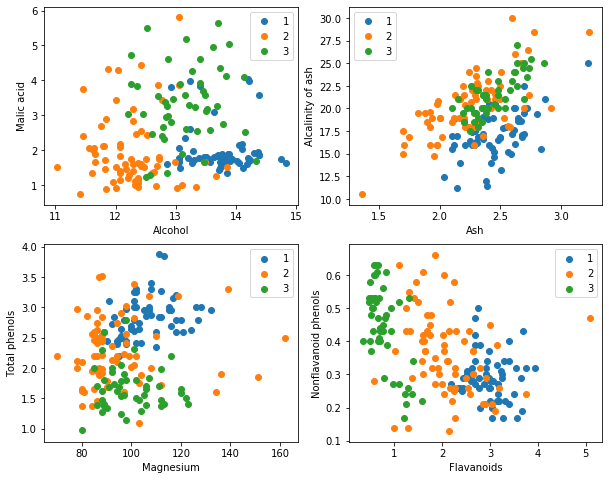

In [5]:
attrs = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
         'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
         'OD280/OD315 of diluted wines', 'Proline']
plt.figure(figsize=(10, 8))
for i in range(0, 4):
    plt.subplot(2, 2, i+1)
    a1, a2 = 2 * i, 2 * i + 1
    plt.scatter(X[:59, a1], X[:59, a2], label='1')
    plt.scatter(X[59:130, a1], X[59:130, a2], label='2')
    plt.scatter(X[130:, a1], X[130:, a2], label='3')
    plt.xlabel(attrs[a1])
    plt.ylabel(attrs[a2])
    plt.legend()
plt.show()


#### 将数据集按128:50划分为训练集（已知类别样本）和验证集（待验证样本）：

In [6]:
train_idx = np.random.choice(178, 128, replace=False)
test_idx = np.array(list(set(range(178)) - set(train_idx)))
X_train, Y_train = X[train_idx], Y[train_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

### 步骤三 计算距离
利用MindSpore提供的`tile, suqare, ReduceSum, sqrt, TopK`等算子，通过矩阵运算的方式同时计算输入样本x和已明确分类的其他样本X_train的距离，并计算出top k近邻

In [7]:
class KnnNet(nn.Cell):
    def __init__(self, k):
        super(KnnNet, self).__init__()
        self.tile = P.Tile()
        self.sum = P.ReduceSum()
        self.topk = P.TopK()
        self.k = k

    def construct(self, x, X_train):
        # Tile input x to match the number of samples in X_train
        x_tile = self.tile(x, (128, 1))
        square_diff = F.square(x_tile - X_train)
        square_dist = self.sum(square_diff, 1)
        dist = F.sqrt(square_dist)
        # -dist mean the bigger the value is, the nearer the samples are
        values, indices = self.topk(-dist, self.k)
        return indices


def knn(knn_net, x, X_train, Y_train):
    x, X_train = ms.Tensor(x), ms.Tensor(X_train)
    indices = knn_net(x, X_train)
    topk_cls = [0]*len(indices.asnumpy())
    for idx in indices.asnumpy():
        topk_cls[Y_train[idx]] += 1
    cls = np.argmax(topk_cls)
    return cls

### 步骤四 预测
在验证集上验证KNN算法的有效性，取$k = 5$，验证精度接近80%，说明KNN算法在该3分类任务上有效，能根据酒的13种属性判断出酒的品种。

In [9]:
acc = 0
knn_net = KnnNet(5)
for x, y in zip(X_test, Y_test):
    pred = knn(knn_net, x, X_train, Y_train)
    acc += (pred == y)
    print('label: %d, prediction: %s' % (y, pred))
print('Validation accuracy is %f' % (acc/len(Y_test)))

label: 2, prediction: 3
label: 1, prediction: 1
label: 1, prediction: 1
label: 3, prediction: 3
label: 3, prediction: 3
label: 1, prediction: 1
label: 3, prediction: 3
label: 1, prediction: 1
label: 3, prediction: 1
label: 3, prediction: 3
label: 1, prediction: 1
label: 3, prediction: 3
label: 3, prediction: 1
label: 3, prediction: 3
label: 3, prediction: 3
label: 1, prediction: 1
label: 3, prediction: 3
label: 1, prediction: 3
label: 1, prediction: 1
label: 3, prediction: 2
label: 1, prediction: 1
label: 3, prediction: 3
label: 1, prediction: 1
label: 1, prediction: 1
label: 3, prediction: 2
label: 3, prediction: 2
label: 1, prediction: 1
label: 3, prediction: 1
label: 3, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 2, prediction: 2
label: 2, prediction: 3
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 3
label: 2, predic

## 实验小结
本实验使用MindSpore实现了KNN算法，用来解决3分类问题。取wine数据集上的3类样本，分为已知类别样本和待验证样本，从验证结果可以看出KNN算法在该任务上有效，能根据酒的13种属性判断出酒的品种。
